# NNTI Assignment 8 (Q8.4)

Name 1: Sayeh Jarollahi<br>
Student id 1: 7073520<br>
Email 1: saja00006@stud.uni-saarland.de<br>

Name 2: Mahsa Amani<br>
Student id 2: 7064006 <br>
Email 2: maam00002@stud.uni-saarland.de <br>

Name 3: <br>
Student id 3:  <br>
Email 3: <br>

**Instructions:** Read each question carefully. <br/>
Make sure you appropriately comment your code wherever required. Your final submission should contain the completed Notebook and the respective  files for any additional exercises necessary. There is no need to resubmit the data files should they be provided separately. <br>


Upload the zipped folder on CMS. Please follow the naming convention of **Name1_id1_Name2_id2_Name3_id3.zip **. Only one member of the group should make the submisssion.


In this exercise you will build your own neural networks, but this time you need to add regularization in the form of dropout, weight-decay and early-stopping.

Each layer should have the option of using dropout. Your code needs to allow for this flexibility.

Additionally, adding weight-decay and early-stopping should also be optional upon creation.

**NOTE**:
1. You are allowed to use built-in functions from pytorch to incorporate this functionality.

2. We recommend the use of GPUs or Google collab for this exercise.

3. During training and validation, remember when to use `model.train()` and `model.eval()`

Use the below imports, as usual you are allowed to import additional packages, but mention the reason you're using them

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

## a. Implement a regularized model [0.5 points]

In this task, you will implement a custom neural network model using PyTorch. The model should incorporate key features such as **dropout** to improve generalization and prevent overfitting.

**Tasks to implement**:

1. Define the Model Architecture:
  - The model consists of a series of fully connected (FC) layers with ReLU activations in between.
  - Dropout layers are added after each hidden layer, with the probability of dropout specified by the `dropout_p` parameter.
  - The final output layer produces a result that is passed through a Softmax activation for multi-class classification tasks.

**Hint**:
Since you're not implementing a CNN, but rather a simple ANN network, it is recommended to flatten your input images when pushing into the network.

In [47]:
class Model(nn.Module):
    """
    A neural network model incorporating dropout.

    Args:
        input_dim (int): Dimensionality of the input features.
        hidden_dim (int): Number of units in each hidden layer.
        out_dim (int): Number of output units (number of classes).
        num_layers (int): Number of hidden layers.
        dropout (list of bool): Specifies which hidden layers will have dropout.
        dropout_p (float): Dropout probability used for the Dropout layers.
    """

    def __init__(self, input_dim, hidden_dim, out_dim, num_layers, dropout, dropout_p):
        #TODO
        super(Model, self).__init__()
        
        self.hidden_layers = nn.ModuleList()
        self.dropouts = []

        # Input layer
        self.input_layer = nn.Linear(input_dim, hidden_dim)

        # Hidden layers
        for i in range(num_layers):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.dropouts.append(nn.Dropout(dropout_p) if dropout[i] else None)

        # Output layer
        self.output_layer = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        #TODO
        # Flattenning input
        x = x.view(x.size(0), -1)
        
        # Input layer
        x = self.input_layer(x)
        x = torch.nn.functional.relu(x)

        # Hidden layers
        for i, layer in enumerate(self.hidden_layers):
            x = torch.nn.functional.relu(layer(x))
            if self.dropouts[i]:
                x = self.dropouts[i](x)
        
        # Final output layer with Softmax
        x = self.output_layer(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

### b. Data and code setup [1 + 0.25 + 0.25 = 1.5 points]

You will use the MNIST dataset for these experiments. The data setup has been provided for you.<br> **DO NOT CHANGE THE CODE HERE.**

In [3]:
# Load the data
# DO NOT CHANGE THE CODE IN THIS CELL
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(mnist_train))  # 80% for training
val_size = len(mnist_train) - train_size  # 20% for validation

# Split the dataset into training and validation
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [train_size, val_size])

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Training code
The `trainer()` function trains a model using the provided data loaders, criterion (loss function), optimizer, and various options for regularization and early stopping. You will implement this function for training models for the experiments.

Few things to keep in mind:
- The function should accept model, data loaders, loss function, optimizer, and training configurations (epochs, early stopping).
- The training loop should include forward pass, loss computation, backward pass, and weight update.
- Track and return average training and validation losses for each epoch.
- Use tqdm for progress bars during training and validation. (**optional**, but recommended)
- Implement **early stopping** to halt training if validation loss doesn't improve for a set number of epochs. Provide a `patience` parameter as the number of epochs to wait until validation loss improves.
  - Make it optional by passing a boolean param `early_stopping`.

In [6]:
# to show progress bar 
from tqdm import tqdm

In [7]:
def trainer(model, train_loader, val_loader, criterion, optimizer, epochs=50, early_stopping=False, patience=10):
    """
    Train the model with optional early stopping.

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (DataLoader): The training data loader.
        val_loader (DataLoader): The validation data loader.
        criterion (loss function): The loss function.
        optimizer (Optimizer): The optimizer to use.
        epochs (int, optional): The number of epochs to train. Default is 50.
        early_stopping (bool, optional): Whether to apply early stopping. Default is False.
        patience (int, optional): The patience for early stopping. Default is 10.

    Returns:
        model (torch.nn.Module): The trained model.
        train_losses (list): List of average training losses per epoch.
        val_losses (list): List of average validation losses per epoch.
    """
    #TODO
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_wo_improve = 0

    for epoch in range(epochs):
        model.train()
        train_loss_per_epoch = 0.0
        
        # Training loop
        for inputs, targets in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss_per_epoch += loss.item()

        avg_train_loss = train_loss_per_epoch / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()
        val_loss_per_epoch = 0.0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader):
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss_per_epoch += loss.item()

        avg_val_loss = val_loss_per_epoch / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Early stopping logic
        if early_stopping:
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_wo_improve = 0
                best_model_state = model.state_dict()
            else:
                epochs_wo_improve += 1

            if epochs_wo_improve >= patience:
                print(f"Early stopping triggered after no improvement for {patience} epochs!")
                model.load_state_dict(best_model_state)
                break

    return model, train_losses, val_losses

#### Evaluation code

Complete the `plot_losses()` function and `evaluate_model()` to visualize the training and validation losses and to evaluate the model over the test set.

**NOTE**:
1. Add a legend, title, and grid to improve plot readability for `plot_losses()`
2. Report the average test loss, accuracy, and F1 score metrics using `evaluate_model()`.


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

def plot_losses(train_losses, val_losses):
    """
    Plot training and validation losses.

    Args:
        train_losses (list): List of average training losses per epoch.
        val_losses (list): List of average validation losses per epoch.
    """
    #TODO
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()


def evaluate_model(model, test_loader, criterion):
    """
    Evaluate the model on the test set and report accuracy and F1 score.

    Args:
        model (torch.nn.Module): The trained model to be evaluated.
        test_loader (DataLoader): The test data loader.
        criterion (loss function): The loss function to use for evaluation.

    Returns:
        float: The average test loss.
        float: The accuracy of the model on the test set.
        float: The F1 score of the model on the test set.
    """
    #TODO
    model.eval()
    total_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            all_targets += targets.tolist()
            all_predictions += predictions.tolist()

    avg_test_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

    return avg_test_loss, accuracy, f1

## c. Experiments: [0.25+0.25+0.25+0.25 = 1 point]
Build a deep network using 3 hidden layers, so in total including input and output layers, it should be a 5-layer network. You will run the following 4 experiments on this network with the given configurations:

1. Deep network (at least 3 hidden layers)
2. Deep regularized network (with weight-decay enabled)
3. Deep regularized network (with weight-decay and dropout)
4. Deep regularized network (with weight-decay and early-stopping)

Report Accuracy and $F_1$ metrics on the `test set` for your experiments and discuss your results. What did you expect to see and what did you end up seeing.

**NOTE**:
- You can choose how you use regularization. Ideally you would experiment with various parameters for this regularization, the 4 listed variants are merely what you must cover as a minimum. You are free to run more experiments if you want to.
- In the end, report results for all your experiments on the test set concisely  in a table at the end.
- Use the Adam optimizer for all of your experiments.

### Experiment 1: Deep network (at least 3 hidden layers) (No Regularization)

Use the given model configs and hyperparams to run the experiments.

In [23]:
import torch.optim as optim

# Deep network (3 hidden layers) with no dropout and no weight-decay
model_1_config = {
    "input_dim": 28 * 28,
    "hidden_dim": 400,
    "out_dim": 10,
    "num_layers": 3,
    "dropout": [False, False, False],
    "dropout_p": 0.5
}


learning_rate = 5e-5
weight_decay = 0  # Use this only if weight-decay is needed

100%|██████████| 188/188 [00:00<00:00, 385.32it/s]


Epoch 1/50, Training Loss: 1.7925, Validation Loss: 1.6029


100%|██████████| 188/188 [00:00<00:00, 384.07it/s]


Epoch 2/50, Training Loss: 1.5875, Validation Loss: 1.5769


100%|██████████| 188/188 [00:00<00:00, 386.52it/s]


Epoch 3/50, Training Loss: 1.5658, Validation Loss: 1.5557


100%|██████████| 188/188 [00:00<00:00, 373.75it/s]


Epoch 4/50, Training Loss: 1.5545, Validation Loss: 1.5462


100%|██████████| 188/188 [00:00<00:00, 369.04it/s]


Epoch 5/50, Training Loss: 1.5469, Validation Loss: 1.5426


100%|██████████| 188/188 [00:00<00:00, 364.64it/s]


Epoch 6/50, Training Loss: 1.5400, Validation Loss: 1.5460


100%|██████████| 188/188 [00:00<00:00, 362.41it/s]


Epoch 7/50, Training Loss: 1.5351, Validation Loss: 1.5410


100%|██████████| 188/188 [00:00<00:00, 342.84it/s]


Epoch 8/50, Training Loss: 1.5289, Validation Loss: 1.5277


100%|██████████| 188/188 [00:00<00:00, 355.96it/s]


Epoch 9/50, Training Loss: 1.5242, Validation Loss: 1.5245


100%|██████████| 188/188 [00:00<00:00, 344.30it/s]


Epoch 10/50, Training Loss: 1.5201, Validation Loss: 1.5227


100%|██████████| 188/188 [00:00<00:00, 352.24it/s]


Epoch 11/50, Training Loss: 1.5172, Validation Loss: 1.5176


100%|██████████| 188/188 [00:00<00:00, 349.63it/s]


Epoch 12/50, Training Loss: 1.5136, Validation Loss: 1.5150


100%|██████████| 188/188 [00:00<00:00, 351.68it/s]


Epoch 13/50, Training Loss: 1.5105, Validation Loss: 1.5124


100%|██████████| 188/188 [00:00<00:00, 349.57it/s]


Epoch 14/50, Training Loss: 1.5078, Validation Loss: 1.5139


100%|██████████| 188/188 [00:00<00:00, 350.27it/s]


Epoch 15/50, Training Loss: 1.5045, Validation Loss: 1.5101


100%|██████████| 188/188 [00:00<00:00, 339.48it/s]


Epoch 16/50, Training Loss: 1.5022, Validation Loss: 1.5053


100%|██████████| 188/188 [00:00<00:00, 339.50it/s]


Epoch 17/50, Training Loss: 1.5004, Validation Loss: 1.5096


100%|██████████| 188/188 [00:00<00:00, 343.14it/s]


Epoch 18/50, Training Loss: 1.4989, Validation Loss: 1.5037


100%|██████████| 188/188 [00:00<00:00, 342.14it/s]


Epoch 19/50, Training Loss: 1.4968, Validation Loss: 1.5046


100%|██████████| 188/188 [00:00<00:00, 313.69it/s]


Epoch 20/50, Training Loss: 1.4947, Validation Loss: 1.4977


100%|██████████| 188/188 [00:00<00:00, 335.52it/s]


Epoch 21/50, Training Loss: 1.4934, Validation Loss: 1.4991


100%|██████████| 188/188 [00:00<00:00, 324.33it/s]


Epoch 22/50, Training Loss: 1.4917, Validation Loss: 1.4968


100%|██████████| 188/188 [00:00<00:00, 301.35it/s]


Epoch 23/50, Training Loss: 1.4909, Validation Loss: 1.5006


100%|██████████| 188/188 [00:00<00:00, 305.64it/s]


Epoch 24/50, Training Loss: 1.4891, Validation Loss: 1.4966


100%|██████████| 188/188 [00:00<00:00, 336.05it/s]


Epoch 25/50, Training Loss: 1.4879, Validation Loss: 1.4948


100%|██████████| 188/188 [00:00<00:00, 283.88it/s]


Epoch 26/50, Training Loss: 1.4865, Validation Loss: 1.4946


100%|██████████| 188/188 [00:00<00:00, 338.32it/s]


Epoch 27/50, Training Loss: 1.4863, Validation Loss: 1.4969


100%|██████████| 188/188 [00:00<00:00, 320.60it/s]


Epoch 28/50, Training Loss: 1.4845, Validation Loss: 1.4945


100%|██████████| 188/188 [00:00<00:00, 314.97it/s]


Epoch 29/50, Training Loss: 1.4836, Validation Loss: 1.4935


100%|██████████| 188/188 [00:00<00:00, 322.84it/s]


Epoch 30/50, Training Loss: 1.4831, Validation Loss: 1.4907


100%|██████████| 188/188 [00:00<00:00, 331.11it/s]


Epoch 31/50, Training Loss: 1.4822, Validation Loss: 1.4927


100%|██████████| 188/188 [00:00<00:00, 335.62it/s]


Epoch 32/50, Training Loss: 1.4813, Validation Loss: 1.4883


100%|██████████| 188/188 [00:00<00:00, 337.68it/s]


Epoch 33/50, Training Loss: 1.4804, Validation Loss: 1.4883


100%|██████████| 188/188 [00:00<00:00, 338.45it/s]


Epoch 34/50, Training Loss: 1.4799, Validation Loss: 1.4901


100%|██████████| 188/188 [00:00<00:00, 338.53it/s]


Epoch 35/50, Training Loss: 1.4793, Validation Loss: 1.4870


100%|██████████| 188/188 [00:00<00:00, 320.48it/s]


Epoch 36/50, Training Loss: 1.4790, Validation Loss: 1.4879


100%|██████████| 188/188 [00:00<00:00, 328.13it/s]


Epoch 37/50, Training Loss: 1.4783, Validation Loss: 1.4887


100%|██████████| 188/188 [00:00<00:00, 329.77it/s]


Epoch 38/50, Training Loss: 1.4779, Validation Loss: 1.4877


100%|██████████| 188/188 [00:00<00:00, 323.96it/s]


Epoch 39/50, Training Loss: 1.4773, Validation Loss: 1.4872


100%|██████████| 188/188 [00:00<00:00, 317.23it/s]


Epoch 40/50, Training Loss: 1.4770, Validation Loss: 1.4875


100%|██████████| 188/188 [00:00<00:00, 329.14it/s]


Epoch 41/50, Training Loss: 1.4762, Validation Loss: 1.4884


100%|██████████| 188/188 [00:00<00:00, 324.46it/s]


Epoch 42/50, Training Loss: 1.4760, Validation Loss: 1.4869


100%|██████████| 188/188 [00:00<00:00, 316.15it/s]


Epoch 43/50, Training Loss: 1.4760, Validation Loss: 1.4871


100%|██████████| 188/188 [00:00<00:00, 314.16it/s]


Epoch 44/50, Training Loss: 1.4757, Validation Loss: 1.4879


100%|██████████| 188/188 [00:00<00:00, 317.20it/s]


Epoch 45/50, Training Loss: 1.4749, Validation Loss: 1.4874


100%|██████████| 188/188 [00:00<00:00, 325.09it/s]


Epoch 46/50, Training Loss: 1.4748, Validation Loss: 1.4852


100%|██████████| 188/188 [00:00<00:00, 331.45it/s]


Epoch 47/50, Training Loss: 1.4745, Validation Loss: 1.4903


100%|██████████| 188/188 [00:00<00:00, 323.50it/s]


Epoch 48/50, Training Loss: 1.4745, Validation Loss: 1.4863


100%|██████████| 188/188 [00:00<00:00, 328.11it/s]


Epoch 49/50, Training Loss: 1.4737, Validation Loss: 1.4860


100%|██████████| 188/188 [00:00<00:00, 318.16it/s]


Epoch 50/50, Training Loss: 1.4737, Validation Loss: 1.4859


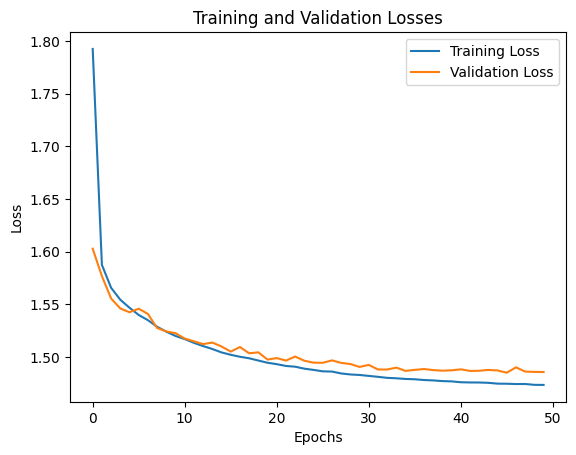

Test Loss: 1.4874
Test Accuracy: 0.9744
Test F1 Score: 0.9744


In [30]:
# Train the model
model_1 = Model(**model_1_config)
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
model_1, train_losses, val_losses = trainer(model_1, train_dl, val_dl, criterion, optimizer)

# Plot the training and validation losses
plot_losses(train_losses, val_losses)

# Evaluate the model on the test set
test_loss, test_accuracy, test_f1 = evaluate_model(model_1, test_dl, criterion)

In [31]:
# to show all the metrics in a dataframe
import pandas as pd

df = pd.DataFrame(columns=["Configuration", "Test Loss", "Test Accuracy", "Test F1-score"])

In [32]:
df.loc[len(df)] = ["Deep network", test_loss, test_accuracy, test_f1]

### Experiment 2: Deep regularized network (with weight-decay enabled)

Use the given model configs to run the experiments.

In [34]:
# Deep network (3 hidden layers) with weight-decay but no dropout
model_2_config = {
    "input_dim": 28 * 28,
    "hidden_dim": 400,
    "out_dim": 10,
    "num_layers": 3,
    "dropout": [False, False, False],
    "dropout_p": 0.5
}


learning_rate = 5e-5
weight_decay = 1e-4  # Use this only if weight-decay is needed

100%|██████████| 188/188 [00:00<00:00, 382.19it/s]


Epoch 1/50, Training Loss: 1.7862, Validation Loss: 1.6244


100%|██████████| 188/188 [00:00<00:00, 380.47it/s]


Epoch 2/50, Training Loss: 1.5987, Validation Loss: 1.5774


100%|██████████| 188/188 [00:00<00:00, 370.84it/s]


Epoch 3/50, Training Loss: 1.5745, Validation Loss: 1.5619


100%|██████████| 188/188 [00:00<00:00, 358.28it/s]


Epoch 4/50, Training Loss: 1.5608, Validation Loss: 1.5558


100%|██████████| 188/188 [00:00<00:00, 363.94it/s]


Epoch 5/50, Training Loss: 1.5514, Validation Loss: 1.5481


100%|██████████| 188/188 [00:00<00:00, 360.26it/s]


Epoch 6/50, Training Loss: 1.5437, Validation Loss: 1.5392


100%|██████████| 188/188 [00:00<00:00, 358.09it/s]


Epoch 7/50, Training Loss: 1.5371, Validation Loss: 1.5363


100%|██████████| 188/188 [00:00<00:00, 355.77it/s]


Epoch 8/50, Training Loss: 1.5314, Validation Loss: 1.5298


100%|██████████| 188/188 [00:00<00:00, 355.24it/s]


Epoch 9/50, Training Loss: 1.5267, Validation Loss: 1.5265


100%|██████████| 188/188 [00:00<00:00, 353.66it/s]


Epoch 10/50, Training Loss: 1.5221, Validation Loss: 1.5252


100%|██████████| 188/188 [00:00<00:00, 343.07it/s]


Epoch 11/50, Training Loss: 1.5188, Validation Loss: 1.5187


100%|██████████| 188/188 [00:00<00:00, 348.67it/s]


Epoch 12/50, Training Loss: 1.5154, Validation Loss: 1.5169


100%|██████████| 188/188 [00:00<00:00, 344.65it/s]


Epoch 13/50, Training Loss: 1.5121, Validation Loss: 1.5176


100%|██████████| 188/188 [00:00<00:00, 347.56it/s]


Epoch 14/50, Training Loss: 1.5087, Validation Loss: 1.5094


100%|██████████| 188/188 [00:00<00:00, 328.04it/s]


Epoch 15/50, Training Loss: 1.5062, Validation Loss: 1.5107


100%|██████████| 188/188 [00:00<00:00, 341.09it/s]


Epoch 16/50, Training Loss: 1.5037, Validation Loss: 1.5064


100%|██████████| 188/188 [00:00<00:00, 339.87it/s]


Epoch 17/50, Training Loss: 1.5015, Validation Loss: 1.5054


100%|██████████| 188/188 [00:00<00:00, 339.12it/s]


Epoch 18/50, Training Loss: 1.4986, Validation Loss: 1.5057


100%|██████████| 188/188 [00:00<00:00, 337.89it/s]


Epoch 19/50, Training Loss: 1.4969, Validation Loss: 1.5016


100%|██████████| 188/188 [00:00<00:00, 334.06it/s]


Epoch 20/50, Training Loss: 1.4956, Validation Loss: 1.4977


100%|██████████| 188/188 [00:00<00:00, 337.94it/s]


Epoch 21/50, Training Loss: 1.4945, Validation Loss: 1.4988


100%|██████████| 188/188 [00:00<00:00, 323.54it/s]


Epoch 22/50, Training Loss: 1.4925, Validation Loss: 1.5017


100%|██████████| 188/188 [00:00<00:00, 312.71it/s]


Epoch 23/50, Training Loss: 1.4911, Validation Loss: 1.4994


100%|██████████| 188/188 [00:00<00:00, 328.91it/s]


Epoch 24/50, Training Loss: 1.4901, Validation Loss: 1.4946


100%|██████████| 188/188 [00:00<00:00, 320.71it/s]


Epoch 25/50, Training Loss: 1.4887, Validation Loss: 1.4950


100%|██████████| 188/188 [00:00<00:00, 289.51it/s]


Epoch 26/50, Training Loss: 1.4880, Validation Loss: 1.4939


100%|██████████| 188/188 [00:00<00:00, 324.10it/s]


Epoch 27/50, Training Loss: 1.4862, Validation Loss: 1.4920


100%|██████████| 188/188 [00:00<00:00, 320.31it/s]


Epoch 28/50, Training Loss: 1.4853, Validation Loss: 1.4922


100%|██████████| 188/188 [00:00<00:00, 322.11it/s]


Epoch 29/50, Training Loss: 1.4845, Validation Loss: 1.4932


100%|██████████| 188/188 [00:00<00:00, 311.59it/s]


Epoch 30/50, Training Loss: 1.4835, Validation Loss: 1.4912


100%|██████████| 188/188 [00:00<00:00, 324.39it/s]


Epoch 31/50, Training Loss: 1.4824, Validation Loss: 1.4910


100%|██████████| 188/188 [00:00<00:00, 329.63it/s]


Epoch 32/50, Training Loss: 1.4818, Validation Loss: 1.4903


100%|██████████| 188/188 [00:00<00:00, 269.99it/s]


Epoch 33/50, Training Loss: 1.4816, Validation Loss: 1.4898


100%|██████████| 188/188 [00:00<00:00, 297.74it/s]


Epoch 34/50, Training Loss: 1.4804, Validation Loss: 1.4919


100%|██████████| 188/188 [00:00<00:00, 327.53it/s]


Epoch 35/50, Training Loss: 1.4799, Validation Loss: 1.4876


100%|██████████| 188/188 [00:00<00:00, 319.82it/s]


Epoch 36/50, Training Loss: 1.4794, Validation Loss: 1.4877


100%|██████████| 188/188 [00:00<00:00, 308.31it/s]


Epoch 37/50, Training Loss: 1.4790, Validation Loss: 1.4899


100%|██████████| 188/188 [00:00<00:00, 316.06it/s]


Epoch 38/50, Training Loss: 1.4781, Validation Loss: 1.4878


100%|██████████| 188/188 [00:00<00:00, 320.50it/s]


Epoch 39/50, Training Loss: 1.4775, Validation Loss: 1.4878


100%|██████████| 188/188 [00:00<00:00, 322.54it/s]


Epoch 40/50, Training Loss: 1.4775, Validation Loss: 1.4893


100%|██████████| 188/188 [00:00<00:00, 319.45it/s]


Epoch 41/50, Training Loss: 1.4772, Validation Loss: 1.4874


100%|██████████| 188/188 [00:00<00:00, 321.38it/s]


Epoch 42/50, Training Loss: 1.4763, Validation Loss: 1.4867


100%|██████████| 188/188 [00:00<00:00, 321.22it/s]


Epoch 43/50, Training Loss: 1.4762, Validation Loss: 1.4860


100%|██████████| 188/188 [00:00<00:00, 321.86it/s]


Epoch 44/50, Training Loss: 1.4758, Validation Loss: 1.4883


100%|██████████| 188/188 [00:00<00:00, 319.39it/s]


Epoch 45/50, Training Loss: 1.4757, Validation Loss: 1.4851


100%|██████████| 188/188 [00:00<00:00, 319.85it/s]


Epoch 46/50, Training Loss: 1.4751, Validation Loss: 1.4873


100%|██████████| 188/188 [00:00<00:00, 306.38it/s]


Epoch 47/50, Training Loss: 1.4749, Validation Loss: 1.4867


100%|██████████| 188/188 [00:00<00:00, 318.45it/s]


Epoch 48/50, Training Loss: 1.4743, Validation Loss: 1.4884


100%|██████████| 188/188 [00:00<00:00, 318.76it/s]


Epoch 49/50, Training Loss: 1.4745, Validation Loss: 1.4868


100%|██████████| 188/188 [00:00<00:00, 319.33it/s]


Epoch 50/50, Training Loss: 1.4739, Validation Loss: 1.4838


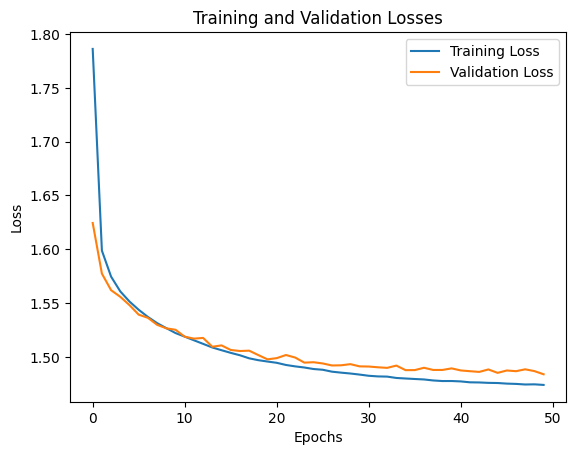

Test Loss: 1.4876
Test Accuracy: 0.9749
Test F1 Score: 0.9749


In [35]:
# Train the model
model_2 = Model(**model_2_config)
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
model_2, train_losses, val_losses = trainer(model_2, train_dl, val_dl, criterion, optimizer)

# Plot the training and validation losses
plot_losses(train_losses, val_losses)

# Evaluate the model on the test set
test_loss, test_accuracy, test_f1 = evaluate_model(model_2, test_dl, criterion)

In [36]:
df.loc[len(df)] = ["Deep regularized network (with weight-decay enabled)", test_loss, test_accuracy, test_f1]

### Experiment 3: Deep regularized network (with weight-decay and dropout)

Use the given model configs to run the experiments.

In [37]:
# Deep regularized network (3 hidden layers) with weight-decay and dropout after every layer
model_3_config = {
    "input_dim": 28 * 28,
    "hidden_dim": 400,
    "out_dim": 10,
    "num_layers": 3,
    "dropout": [True, True, True],
    "dropout_p": 0.5
}

learning_rate = 5e-5
weight_decay = 1e-4  # Use this only if weight-decay is needed

100%|██████████| 188/188 [00:00<00:00, 334.71it/s]


Epoch 1/50, Training Loss: 1.9907, Validation Loss: 1.7737


100%|██████████| 188/188 [00:00<00:00, 301.76it/s]


Epoch 2/50, Training Loss: 1.7052, Validation Loss: 1.6709


100%|██████████| 188/188 [00:00<00:00, 316.75it/s]


Epoch 3/50, Training Loss: 1.6587, Validation Loss: 1.6469


100%|██████████| 188/188 [00:00<00:00, 313.86it/s]


Epoch 4/50, Training Loss: 1.6112, Validation Loss: 1.5887


100%|██████████| 188/188 [00:00<00:00, 316.08it/s]


Epoch 5/50, Training Loss: 1.5802, Validation Loss: 1.5719


100%|██████████| 188/188 [00:00<00:00, 290.50it/s]


Epoch 6/50, Training Loss: 1.5636, Validation Loss: 1.5566


100%|██████████| 188/188 [00:00<00:00, 307.15it/s]


Epoch 7/50, Training Loss: 1.5525, Validation Loss: 1.5472


100%|██████████| 188/188 [00:00<00:00, 307.60it/s]


Epoch 8/50, Training Loss: 1.5445, Validation Loss: 1.5405


100%|██████████| 188/188 [00:00<00:00, 296.74it/s]


Epoch 9/50, Training Loss: 1.5378, Validation Loss: 1.5333


100%|██████████| 188/188 [00:00<00:00, 305.09it/s]


Epoch 10/50, Training Loss: 1.5308, Validation Loss: 1.5308


100%|██████████| 188/188 [00:00<00:00, 295.52it/s]


Epoch 11/50, Training Loss: 1.5266, Validation Loss: 1.5280


100%|██████████| 188/188 [00:00<00:00, 262.53it/s]


Epoch 12/50, Training Loss: 1.5215, Validation Loss: 1.5234


100%|██████████| 188/188 [00:00<00:00, 296.32it/s]


Epoch 13/50, Training Loss: 1.5176, Validation Loss: 1.5177


100%|██████████| 188/188 [00:00<00:00, 294.97it/s]


Epoch 14/50, Training Loss: 1.5152, Validation Loss: 1.5169


100%|██████████| 188/188 [00:00<00:00, 289.05it/s]


Epoch 15/50, Training Loss: 1.5110, Validation Loss: 1.5147


100%|██████████| 188/188 [00:00<00:00, 282.00it/s]


Epoch 16/50, Training Loss: 1.5076, Validation Loss: 1.5100


100%|██████████| 188/188 [00:00<00:00, 285.69it/s]


Epoch 17/50, Training Loss: 1.5066, Validation Loss: 1.5111


100%|██████████| 188/188 [00:00<00:00, 287.24it/s]


Epoch 18/50, Training Loss: 1.5041, Validation Loss: 1.5062


100%|██████████| 188/188 [00:00<00:00, 292.23it/s]


Epoch 19/50, Training Loss: 1.5027, Validation Loss: 1.5056


100%|██████████| 188/188 [00:00<00:00, 296.15it/s]


Epoch 20/50, Training Loss: 1.5003, Validation Loss: 1.5010


100%|██████████| 188/188 [00:00<00:00, 294.52it/s]


Epoch 21/50, Training Loss: 1.4980, Validation Loss: 1.5064


100%|██████████| 188/188 [00:00<00:00, 295.28it/s]


Epoch 22/50, Training Loss: 1.4971, Validation Loss: 1.4996


100%|██████████| 188/188 [00:00<00:00, 297.72it/s]


Epoch 23/50, Training Loss: 1.4959, Validation Loss: 1.5056


100%|██████████| 188/188 [00:00<00:00, 292.83it/s]


Epoch 24/50, Training Loss: 1.4943, Validation Loss: 1.4993


100%|██████████| 188/188 [00:00<00:00, 283.52it/s]


Epoch 25/50, Training Loss: 1.4929, Validation Loss: 1.4988


100%|██████████| 188/188 [00:00<00:00, 291.26it/s]


Epoch 26/50, Training Loss: 1.4914, Validation Loss: 1.4988


100%|██████████| 188/188 [00:00<00:00, 294.73it/s]


Epoch 27/50, Training Loss: 1.4901, Validation Loss: 1.4953


100%|██████████| 188/188 [00:00<00:00, 294.59it/s]


Epoch 28/50, Training Loss: 1.4897, Validation Loss: 1.4941


100%|██████████| 188/188 [00:00<00:00, 283.29it/s]


Epoch 29/50, Training Loss: 1.4883, Validation Loss: 1.4937


100%|██████████| 188/188 [00:00<00:00, 297.36it/s]


Epoch 30/50, Training Loss: 1.4886, Validation Loss: 1.4938


100%|██████████| 188/188 [00:00<00:00, 294.73it/s]


Epoch 31/50, Training Loss: 1.4864, Validation Loss: 1.4950


100%|██████████| 188/188 [00:00<00:00, 295.26it/s]


Epoch 32/50, Training Loss: 1.4867, Validation Loss: 1.4943


100%|██████████| 188/188 [00:00<00:00, 295.58it/s]


Epoch 33/50, Training Loss: 1.4852, Validation Loss: 1.4936


100%|██████████| 188/188 [00:00<00:00, 298.63it/s]


Epoch 34/50, Training Loss: 1.4847, Validation Loss: 1.4923


100%|██████████| 188/188 [00:00<00:00, 296.65it/s]


Epoch 35/50, Training Loss: 1.4834, Validation Loss: 1.4924


100%|██████████| 188/188 [00:00<00:00, 295.11it/s]


Epoch 36/50, Training Loss: 1.4835, Validation Loss: 1.4917


100%|██████████| 188/188 [00:00<00:00, 296.16it/s]


Epoch 37/50, Training Loss: 1.4828, Validation Loss: 1.4924


100%|██████████| 188/188 [00:00<00:00, 294.29it/s]


Epoch 38/50, Training Loss: 1.4814, Validation Loss: 1.4905


100%|██████████| 188/188 [00:00<00:00, 295.16it/s]


Epoch 39/50, Training Loss: 1.4814, Validation Loss: 1.4897


100%|██████████| 188/188 [00:00<00:00, 292.67it/s]


Epoch 40/50, Training Loss: 1.4809, Validation Loss: 1.4895


100%|██████████| 188/188 [00:00<00:00, 294.86it/s]


Epoch 41/50, Training Loss: 1.4804, Validation Loss: 1.4890


100%|██████████| 188/188 [00:00<00:00, 280.97it/s]


Epoch 42/50, Training Loss: 1.4806, Validation Loss: 1.4912


100%|██████████| 188/188 [00:00<00:00, 293.42it/s]


Epoch 43/50, Training Loss: 1.4800, Validation Loss: 1.4918


100%|██████████| 188/188 [00:00<00:00, 292.34it/s]


Epoch 44/50, Training Loss: 1.4791, Validation Loss: 1.4867


100%|██████████| 188/188 [00:00<00:00, 297.56it/s]


Epoch 45/50, Training Loss: 1.4784, Validation Loss: 1.4880


100%|██████████| 188/188 [00:00<00:00, 280.89it/s]


Epoch 46/50, Training Loss: 1.4783, Validation Loss: 1.4885


100%|██████████| 188/188 [00:00<00:00, 296.33it/s]


Epoch 47/50, Training Loss: 1.4771, Validation Loss: 1.4872


100%|██████████| 188/188 [00:00<00:00, 295.10it/s]


Epoch 48/50, Training Loss: 1.4774, Validation Loss: 1.4871


100%|██████████| 188/188 [00:00<00:00, 294.08it/s]


Epoch 49/50, Training Loss: 1.4771, Validation Loss: 1.4877


100%|██████████| 188/188 [00:00<00:00, 291.25it/s]

Epoch 50/50, Training Loss: 1.4764, Validation Loss: 1.4868


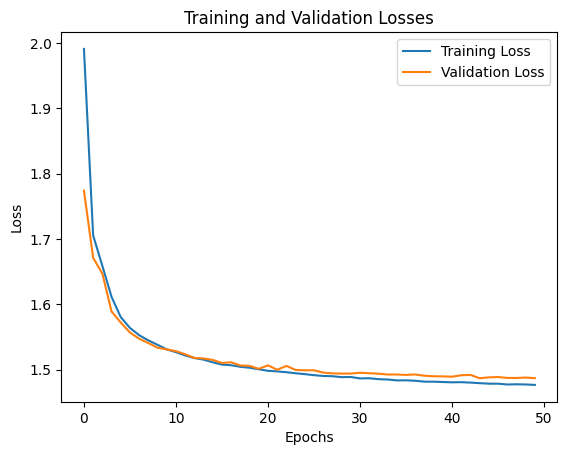

Test Loss: 1.4898
Test Accuracy: 0.9722
Test F1 Score: 0.9722


In [38]:
# Train the model
model_3 = Model(**model_3_config)
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
model_3, train_losses, val_losses = trainer(model_3, train_dl, val_dl, criterion, optimizer)

# Plot the training and validation losses
plot_losses(train_losses, val_losses)

# Evaluate the model on the test set
test_loss, test_accuracy, test_f1 = evaluate_model(model_3, test_dl, criterion)

In [39]:
df.loc[len(df)] = ["Deep regularized network (with weight-decay and dropout)", test_loss, test_accuracy, test_f1]

### Experiment 4: Deep regularized network (with weight-decay and early-stopping)

Use the given model configs to run the experiments.

In [40]:
# Deep regularized network (3 hidden layers) with weight-decay and early stopping
model_4_config = {
    "input_dim": 28 * 28,
    "hidden_dim": 400,
    "out_dim": 10,
    "num_layers": 3,
    "dropout": [False, False, False],
    "dropout_p": 0.5
}

learning_rate = 5e-5
weight_decay = 1e-4  # Use this only if weight-decay is needed

100%|██████████| 188/188 [00:00<00:00, 375.45it/s]


Epoch 1/50, Training Loss: 1.8318, Validation Loss: 1.6578


100%|██████████| 188/188 [00:00<00:00, 381.62it/s]


Epoch 2/50, Training Loss: 1.6273, Validation Loss: 1.5881


100%|██████████| 188/188 [00:00<00:00, 370.67it/s]


Epoch 3/50, Training Loss: 1.5739, Validation Loss: 1.5630


100%|██████████| 188/188 [00:00<00:00, 361.96it/s]


Epoch 4/50, Training Loss: 1.5594, Validation Loss: 1.5505


100%|██████████| 188/188 [00:00<00:00, 357.42it/s]


Epoch 5/50, Training Loss: 1.5511, Validation Loss: 1.5450


100%|██████████| 188/188 [00:00<00:00, 353.40it/s]


Epoch 6/50, Training Loss: 1.5439, Validation Loss: 1.5379


100%|██████████| 188/188 [00:00<00:00, 353.63it/s]


Epoch 7/50, Training Loss: 1.5375, Validation Loss: 1.5406


100%|██████████| 188/188 [00:00<00:00, 352.38it/s]


Epoch 8/50, Training Loss: 1.5318, Validation Loss: 1.5310


100%|██████████| 188/188 [00:00<00:00, 351.35it/s]


Epoch 9/50, Training Loss: 1.5272, Validation Loss: 1.5267


100%|██████████| 188/188 [00:00<00:00, 351.66it/s]


Epoch 10/50, Training Loss: 1.5215, Validation Loss: 1.5210


100%|██████████| 188/188 [00:00<00:00, 345.59it/s]


Epoch 11/50, Training Loss: 1.5184, Validation Loss: 1.5178


100%|██████████| 188/188 [00:00<00:00, 346.82it/s]


Epoch 12/50, Training Loss: 1.5146, Validation Loss: 1.5162


100%|██████████| 188/188 [00:00<00:00, 342.61it/s]


Epoch 13/50, Training Loss: 1.5118, Validation Loss: 1.5141


100%|██████████| 188/188 [00:00<00:00, 340.22it/s]


Epoch 14/50, Training Loss: 1.5085, Validation Loss: 1.5155


100%|██████████| 188/188 [00:00<00:00, 340.49it/s]


Epoch 15/50, Training Loss: 1.5058, Validation Loss: 1.5103


100%|██████████| 188/188 [00:00<00:00, 339.43it/s]


Epoch 16/50, Training Loss: 1.5038, Validation Loss: 1.5084


100%|██████████| 188/188 [00:00<00:00, 339.90it/s]


Epoch 17/50, Training Loss: 1.5012, Validation Loss: 1.5118


100%|██████████| 188/188 [00:00<00:00, 322.75it/s]


Epoch 18/50, Training Loss: 1.4995, Validation Loss: 1.5067


100%|██████████| 188/188 [00:00<00:00, 338.70it/s]


Epoch 19/50, Training Loss: 1.4972, Validation Loss: 1.5003


100%|██████████| 188/188 [00:00<00:00, 332.56it/s]


Epoch 20/50, Training Loss: 1.4957, Validation Loss: 1.5060


100%|██████████| 188/188 [00:00<00:00, 333.41it/s]


Epoch 21/50, Training Loss: 1.4937, Validation Loss: 1.4969


100%|██████████| 188/188 [00:00<00:00, 334.59it/s]


Epoch 22/50, Training Loss: 1.4930, Validation Loss: 1.4978


100%|██████████| 188/188 [00:00<00:00, 309.94it/s]


Epoch 23/50, Training Loss: 1.4912, Validation Loss: 1.4980


100%|██████████| 188/188 [00:00<00:00, 323.60it/s]


Epoch 24/50, Training Loss: 1.4905, Validation Loss: 1.4968


100%|██████████| 188/188 [00:00<00:00, 315.19it/s]


Epoch 25/50, Training Loss: 1.4885, Validation Loss: 1.4955


100%|██████████| 188/188 [00:00<00:00, 331.47it/s]


Epoch 26/50, Training Loss: 1.4873, Validation Loss: 1.4930


100%|██████████| 188/188 [00:00<00:00, 324.19it/s]


Epoch 27/50, Training Loss: 1.4867, Validation Loss: 1.4936


100%|██████████| 188/188 [00:00<00:00, 322.55it/s]


Epoch 28/50, Training Loss: 1.4863, Validation Loss: 1.4955


100%|██████████| 188/188 [00:00<00:00, 329.57it/s]


Epoch 29/50, Training Loss: 1.4842, Validation Loss: 1.4910


100%|██████████| 188/188 [00:00<00:00, 325.54it/s]


Epoch 30/50, Training Loss: 1.4832, Validation Loss: 1.4911


100%|██████████| 188/188 [00:00<00:00, 320.02it/s]


Epoch 31/50, Training Loss: 1.4832, Validation Loss: 1.4927


100%|██████████| 188/188 [00:00<00:00, 324.23it/s]


Epoch 32/50, Training Loss: 1.4819, Validation Loss: 1.4938


100%|██████████| 188/188 [00:00<00:00, 325.33it/s]


Epoch 33/50, Training Loss: 1.4819, Validation Loss: 1.4928


100%|██████████| 188/188 [00:00<00:00, 325.34it/s]


Epoch 34/50, Training Loss: 1.4810, Validation Loss: 1.4906


100%|██████████| 188/188 [00:00<00:00, 321.40it/s]


Epoch 35/50, Training Loss: 1.4802, Validation Loss: 1.4903


100%|██████████| 188/188 [00:00<00:00, 324.31it/s]


Epoch 36/50, Training Loss: 1.4801, Validation Loss: 1.4909


100%|██████████| 188/188 [00:00<00:00, 322.93it/s]


Epoch 37/50, Training Loss: 1.4793, Validation Loss: 1.4890


100%|██████████| 188/188 [00:00<00:00, 322.16it/s]


Epoch 38/50, Training Loss: 1.4783, Validation Loss: 1.4887


100%|██████████| 188/188 [00:00<00:00, 320.97it/s]


Epoch 39/50, Training Loss: 1.4788, Validation Loss: 1.4889


100%|██████████| 188/188 [00:00<00:00, 313.16it/s]


Epoch 40/50, Training Loss: 1.4775, Validation Loss: 1.4894


100%|██████████| 188/188 [00:00<00:00, 324.45it/s]


Epoch 41/50, Training Loss: 1.4771, Validation Loss: 1.4871


100%|██████████| 188/188 [00:00<00:00, 318.61it/s]


Epoch 42/50, Training Loss: 1.4771, Validation Loss: 1.4895


100%|██████████| 188/188 [00:00<00:00, 321.96it/s]


Epoch 43/50, Training Loss: 1.4770, Validation Loss: 1.4884


100%|██████████| 188/188 [00:00<00:00, 321.04it/s]


Epoch 44/50, Training Loss: 1.4756, Validation Loss: 1.4863


100%|██████████| 188/188 [00:00<00:00, 319.46it/s]


Epoch 45/50, Training Loss: 1.4751, Validation Loss: 1.4853


100%|██████████| 188/188 [00:00<00:00, 322.79it/s]


Epoch 46/50, Training Loss: 1.4752, Validation Loss: 1.4875


100%|██████████| 188/188 [00:00<00:00, 317.15it/s]


Epoch 47/50, Training Loss: 1.4749, Validation Loss: 1.4858


100%|██████████| 188/188 [00:00<00:00, 321.10it/s]


Epoch 48/50, Training Loss: 1.4742, Validation Loss: 1.4854


100%|██████████| 188/188 [00:00<00:00, 316.52it/s]


Epoch 49/50, Training Loss: 1.4743, Validation Loss: 1.4870


100%|██████████| 188/188 [00:00<00:00, 320.85it/s]


Epoch 50/50, Training Loss: 1.4747, Validation Loss: 1.4860


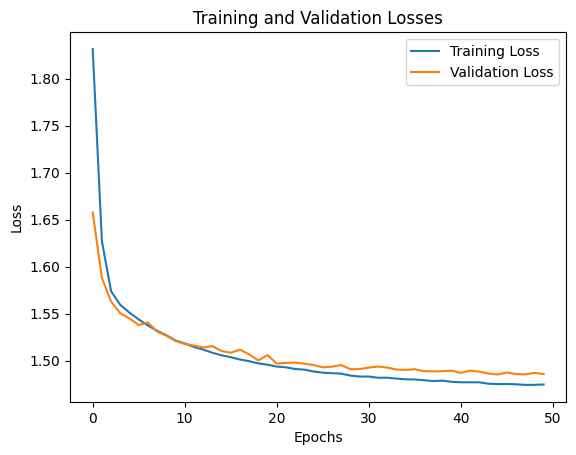

Test Loss: 1.4894
Test Accuracy: 0.9717
Test F1 Score: 0.9717


In [41]:
# Train the model
model_4 = Model(**model_4_config)
optimizer = optim.Adam(model_4.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
model_4, train_losses, val_losses = trainer(model_4, train_dl, val_dl, criterion, optimizer, early_stopping=True)

# Plot the training and validation losses
plot_losses(train_losses, val_losses)

# Evaluate the model on the test set
test_loss, test_accuracy, test_f1 = evaluate_model(model_4, test_dl, criterion)

In [43]:
df.loc[len(df)] = ["Deep regularized network (with weight-decay and early-stopping)", test_loss, test_accuracy, test_f1]

In [51]:
#Report the model accuracies and F1-score on the test set
df

,Configuration,Test Loss,Test Accuracy,Test F1-score
0,Deep network,1.487432,0.9744,0.974398
1,Deep regularized network (with weight-decay en...,1.487568,0.9749,0.974910
2,Deep regularized network (with weight-decay an...,1.489848,0.9722,0.972210
3,Deep regularized network (with weight-decay an...,1.489432,0.9717,0.971675
